In [29]:
import numpy as np
import sympy as sym
import random
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.fft import fft, ifft
from scipy.optimize import line_search
from scipy.linalg import convolution_matrix
from PIL import Image, ImageOps
import time
import colorsys

<ipython-input-30-5f5a3bf95297>:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(x0)


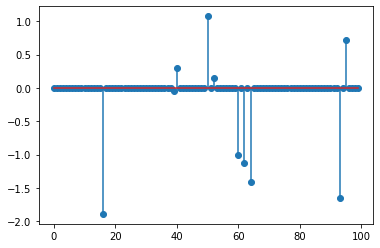

In [30]:
#Initializations
samples = 200;
features = 100;
A = np.random.randn(samples,features)
#Try different matrices
#y = np.random.randn(features)
#Initialize some random sparse solution
x0 = np.zeros((features,1))
p = np.random.permutation(features)
x0[p[:10]] = np.random.randn(10,1)
x0 = np.reshape(x0,-1)
y = A@x0
lam = .9 * np.max( np.abs(A.T @ y))
plt.stem(x0)
plt.show()

samples_t = 50
A_test = np.random.randn(samples_t,features)
y_test = A_test@x0 

#Create array of regularization parameters
lamb = np.array([np.max(np.abs(A.T@y))/50,np.max(np.abs(A.T@y))/25,np.max(np.abs(A.T@y))/10,np.max(np.abs(A.T@y))/5])
lamsz = np.size(lamb)

In [67]:
#Define some helper functions for partial derivatives
def XtimesD(X,D):      #Subroutine to efficiently multiply matrix A by diagonal matrix D from the right.
    m = np.size(X,0)
    n = np.size(X,1)
    XD = np.zeros((m,n))
    for i in range(n):
        XD[:,i] = X[:,i] * D[i,i]
    
    return XD

def DtimesX(D,X):      #Subroutine to efficiently multiply matrix A by diagonal matrix D from the left.
    m = np.size(X,0)
    n = np.size(X,1)
    DX = np.zeros((m,n))
    for i in range(m):
        DX[i,:] = X[i,:] * D[i,i]
    
    return DX

def funcreg(A,x,y,lam):    #Return f(x)+g(x)
    dif = A@x - y
    if (lam == 0):
        return (1/2) * dif.T @ dif
    fxgx = (1/(2*lam))* (dif.T @ dif) + np.linalg.norm(x,1)
    return fxgx
def SubdifTest(A,x,y,lam):          #Subdifferential Test to check for correct solution
    gradf = GradF(A,x,y)/lam
    return max(abs(gradf))
def GradF(A,x,y):                   #Calculate gradient of ||Ax-y||_2^2
    return (((A.T @ A) @ x) - A.T @ y)
def Hessianinv_uu(A,v,it):          #Find the Hessian inverse using neumann series
    n = np.size(v)
    Dv = np.diag(v)
    Hyy = (np.eye(features) + (1/lam)*(Dv @ ((A.T @ A) @ Dv)))
    Lg = np.linalg.norm(Hyy,2)
    Hyy = Hyy/Lg
    Hinv = np.eye(features)
    HyyPow = np.eye(features)-Hyy
    for i in range(it):
        Hinv = Hinv + HyyPow
        HyyPow = HyyPow @ (np.eye(features) - Hyy)
    return (Hinv/(Lg))
def Hessianinv_uu_stc(A,v,b):
    m = np.size(A,0)
    n = np.size(A,1)
    p = np.random.randint(1,b-1)
    Dv = np.diag(v)
    Hyy = np.eye(n) + (1/lam)*(Dv @ ((A.T @ A) @ Dv))
    Lg = np.linalg.norm(Hyy,2)
    #Hlist = np.zeros((m,n,p))
    #for i in range(p):
    #    Ast = np.random.randn(samples,features)
    #    Hlist[:,:,i] = np.eye(features) + (1/lam)*(Dv @ ((Ast.T @ Ast) @ Dv))
    
    Hinv = b*np.eye(n)/Lg
    if (p == 1):
        return Hinv
    
    
    for i in range(p):
        #Ast = np.random.randn(m,n)
        #Ast = np.random.randn(n)
        randint = np.random.randint(0, m)
        Ast = A[randint,:]
        #Hst = np.eye(n) + (1/lam)*(Dv @ ((Ast.T @ Ast) @ Dv))
        Hst = np.eye(n) + (1/lam)*(Dv @ ((np.outer(Ast,Ast)) @ Dv))
        Hinv = Hinv @ (np.eye(n) - (1/Lg)*Hst)
            
    return Hinv

def gnabU(u,v,X,y,lam,s):   #
    #if manually assigning sample X[i], use s as total sample size        CHANGED TO MATVEC
    if (np.size(X) == np.size(v)):
        X = np.array([X])
        return u + s*(1/lam)*v*(np.ravel(X.T @ (X @(v * u))) - np.ravel(X.T * y)) 
    if (s == 1):
        m = np.size(X,0)
        rindx = np.random.randint(m)
        Xi = np.array([X[rindx,:]])
        yi = y[rindx]
        return u + m*(1/lam)*v*(np.ravel(Xi.T @ (Xi @(v * u))) - np.ravel(Xi.T * yi))
        #return lam*u + v*(np.outer(X,X)@(v*u) - X * y)
    
    return u + (1/lam)*v*(X.T @ ((X @(v * u)) - y))
    #return lam*u + v*((X.T @ X)@(v*u) - X.T @ y)

def fnabV(u,v,X,y,lam,s):
    #if manually assigning sample X[i], use s as total sample size        CHANGED TO MATVEC
    if (np.size(X) == np.size(v)):
        X = np.array([X])
        return v + s*(1/lam)*u*(np.ravel(X.T @ (X @(v * u))) - np.ravel(X.T * y)) 
    if (s == 1):
        m = np.size(X,0)
        rindx = np.random.randint(m)
        Xi = np.array([X[rindx,:]])
        yi = y[rindx]
        return v + m*(1/lam)*u*(np.ravel(Xi.T @ (Xi @(v * u))) - np.ravel(Xi.T * yi))
        #return lam*v + u*(np.outer(X,X)@(v*u) - X.T * y)
    
    return v + (1/lam)*u*(X.T @ ((X @(v * u)) - y))
    #return lam*v + u*((X.T @ X)@(v*u) - X.T @ y)
def fnabU(u,v,X,y,lam,s):
    #if manually assigning sample X[i], use s as total sample size        CHANGED TO MATVEC
    if (np.size(X) == np.size(v)):
        X = np.array([X])
        return s*(1/lam)*v*(np.ravel(X.T @ (X @(v * u))) - np.ravel(X.T * y)) 
    if (s == 1):
        m = np.size(X,0)
        rindx = np.random.randint(m)
        Xi = np.array([X[rindx,:]])
        yi = y[rindx]
        return np.ravel(m*(1/lam)*v*(Xi.T @ (Xi @(v * u)) - Xi.T * yi))
        #return v*(np.outer(X,X)@(v*u) - X.T * y)
    
    return (1/lam)*v*(X.T @ ((X @(v * u)) - y))
    #return v*((X.T @ X)@(v*u) - X.T @ y)
def gnabVU(u,v,A,y,lam,s):
    #if manually assigning sample X[i], use s as total sample size        CHANGED TO MATVEC
    if (np.size(A) == np.size(v)):
        A = np.array([A])
        D1 = np.diag(A.T @ (A @ (u * v)))              
        D2 = DtimesX(np.diag(u),A.T) @ XtimesD(A,np.diag(v))      
        D3 = np.diag(A.T * y)
        return (s*(1/lam))*(D1 + D2 - D3)
    if (s == 1):
        m = np.size(A,0)
        rindx = np.random.randint(m)
        Ai = np.array([A[rindx,:]])                  
        yi = y[rindx]
        D1 = np.diag(Ai.T @ (Ai @ (u * v)))
        D2 = DtimesX(np.diag(u),Ai.T) @ XtimesD(Ai,np.diag(v))
        D3 = np.diag(Ai.T * yi)
        return (m*(1/lam))*(D1 + D2 - D3)
        #return (D1 + D2 - D3)
    ATA = A.T @ A                                        
    D1 = np.diag(A.T @ (A @ (u * v)))              
    D2 = DtimesX(np.diag(u),A.T) @ XtimesD(A,np.diag(v))
    D3 = np.diag(A.T @ y)
    return (1/lam)*(D1 + D2 - D3)
    #return (D1 + D2 - D3)
    
#Helper function for calculating the Hessian of (1/lamda)*|A(u*v)-y|_2^2 + |u|_2^2 w.r.t u.
#Set s = 1 for an unbiased sample of the Hessian.
def gnabUU(v,A,y,lam,s):
    n = np.size(v)
    #if manually assigning sample X[i], use s as sample size        CHANGED TO MATVEC
    if (np.size(A) == n):
        A = np.array([A])
        Av = XtimesD(A,np.diag(v))
        return np.eye(n) + (s*(1/lam))*(Av.T @ Av)
    if (s == 1):
        m = np.size(A,0)
        rindx = np.random.randint(m)
        Ai = np.array([A[rindx,:]])
        Av = XtimesD(Ai,np.diag(v))
        return np.eye(n) + (m*(1/lam))*(Av.T @ Av)
        #return lam*np.eye(n) + (np.diag(v) @ (np.outer(A,A) @ np.diag(v)))
    
    Av = XtimesD(A,np.diag(v))
    return np.eye(n) + (1/lam)*(Av.T @ Av)
    #return lam*np.eye(n) + ((np.diag(v) @ A.T) @ (A @ np.diag(v)))
#def Muv(u,v,A,y,lam,s):
#    return gnabVU(u,v,A,y,lam,s) @ np.linalg.inv(gnabUU(v,A,y,lam,s))
def NablaF(u,v,A,y,lam,s):
    #print(np.size(fnabV(u,v,A,y,lam,s)))
    #print(np.size(fnabU(u,v,A,y,lam,s)))
    return (fnabV(u,v,A,y,lam,s) - (gnabVU(u,v,A,y,lam,s) @ (np.linalg.inv(gnabUU(v,A,y,lam,s)) @ fnabU(u,v,A,y,lam,s))))

#The Hessian Inverse Neumann approximation                    
def Hinv_neumann_dir(v,A,lam,b,Lg,grvec):
    Hess = gnabUU(v,A,y,lam,0)                       # n+3 matvecs
    m = np.size(A,0)
    n = np.size(A,1)
    #Lg = np.linalg.norm(Hess,2)                      #Spectral norm found by SVD - has complexity O(n^3) or n matvecs
    normed = (1/Lg)*Hess                             #1 matvec
    #print(np.linalg.norm(normed,2))
    out = grvec
    for i in range(b):
        out = grvec + (np.eye(n) - normed) @ out
        
    return (1/Lg)*out

#The Hessian Inverse Approximation subroutine from Ghadimi
def Hinv_neumann(v,A,lam,b):
    m = np.size(A,0)
    n = np.size(A,1)
    p = np.random.randint(b)
    inv_hess_vals = np.zeros((p,n,n))
    print('p is ', p)
    Hess = np.eye(n) + (1/lam)*((np.diag(v) @ A.T) @ (A @ np.diag(v)))     # n+3 matvecs
    Lg = np.linalg.norm(Hess,2)                    #Spectral norm found by SVD - has complexity O(n^3) or n matvecs
    out = (b/Lg)*np.eye(n)
    #print(np.linalg.norm(out,2))
    if (p == 0):
        return out
    for i in range(p):
        HessS = gnabUU(v,A,y,lam,1)
        out = (np.eye(n) - (1/Lg)*HessS) @ out
        inv_hess_vals[i,:,:] = out
        #print(np.linalg.norm(out,2))
        
    #return out, inv_hess_vals
    return out



#Hessian Inverse Approximation as seen in the LiSSA algorithm
def Hinv_neumannV2(v,A,lam,b,Lg):
    
    #p = np.random.randint(b)
    #print('p is ', p)
    m = np.size(A,0)
    n = np.size(v)
    #Hess = gnabUU(v,A,y,lam,0)
    inv_hess_vals = np.zeros((b,n,n))
    #Lg = np.linalg.norm(Hess,2)
    out = (1/Lg)*np.eye(n)
    #print(np.linalg.norm(out,2))
    #if (p == 0):
        #return out
    for i in range(b):
        HessS = gnabUU(v,A,y,lam,1)
        out = np.eye(n) + (np.eye(n) - (1/Lg)*HessS) @ out
        inv_hess_vals[i,:,:] = out
        #print(np.linalg.norm(out,2))
        
    #return out, inv_hess_vals
    return out

def Hinv_neumannV2_avg(v,A,lam,S2,Lg,S1):
    
    #p = np.random.randint(b)
    #print('p is ', p)
    m = np.size(A,0)
    n = np.size(v)
    #inv_hess_vals = np.zeros((S2,n,n))
    Hess = gnabUU(v,A,y,lam,0)
    Lg = np.linalg.norm(Hess,2)
    #print(np.linalg.norm(out,2))
    #if (p == 0):
        #return out
    inv_hess_avg = np.zeros((n,n))
    for j in range(S1):
        out = (1/Lg)*np.eye(n)
        for i in range(S2):
            HessS = gnabUU(v,A,y,lam,1)
            out = np.eye(n) + (np.eye(n) - (1/Lg)*HessS) @ out
            #inv_hess_vals[i,:,:] = out
        
        inv_hess_avg = inv_hess_avg + out
    
    inv_hess_avg = inv_hess_avg / S1
        
    #return out, inv_hess_vals
    return inv_hess_avg

def Hinv_neumannV2_stoc(v,A,Ai,lam,b,Lg):
    
    #p = np.random.randint(b)
    #print('p is ', p)
    m = np.size(A,0)
    n = np.size(v)
    #Hess = gnabUU(v,A,y,lam,0)
    inv_hess_vals = np.zeros((b,n,n))
    #Lg = np.linalg.norm(Hess,2)
    out = (1/Lg)*np.eye(n)
    #print(np.linalg.norm(out,2))
    #if (p == 0):
        #return out
    for i in range(b):
        HessS = gnabUU(v,Ai,y,lam,m)
        out = np.eye(n) + (np.eye(n) - (1/Lg)*HessS) @ out
        inv_hess_vals[i,:,:] = out
        #print(np.linalg.norm(out,2))
        
    #return out, inv_hess_vals
    return out

#We will use this for the inner loop of BA/HOAG
#SVRG-QUAD - Using the square-loss problem parameter A, we solve Hess * x = z for some z
def SVRG_QUAD(A,z,T,eta):
    features = np.size(A,0)
    samples = np.size(A,1)
    m = 2*features
    xvals = np.zeros((T*m,samples))
    fvals = np.zeros(T*m)
    x = np.random.randn(samples)*0.0001
    #H = A.T @ A
    for i in range(T):
        gradA = (1/features)* (A.T @ (A @ x)) - z
        x0 = x
        for j in range(m):
            rindx = np.random.randint(features)
            Ai = np.array([A[rindx,:]])
            #AitAi = np.outer(A[rindx,:],A[rindx,:])
            gradAi = Ai.T @ (Ai @ x) - z
            gradAix0 = Ai.T @ (Ai @ x0) - z
            x = x - eta*(gradAi - gradAix0 + gradA)
            #print(np.linalg.norm(x,2))
            xvals[i*m + j,:] = x
            #fvals[i*m + j] = np.inner(x,H @ x)/(2*features) - np.inner(x,z)
    
    return xvals, fvals

#SVRG-QUAD - Using the square-loss problem parameter A, we solve Hess * x = z for some z.
#This rendition is for the Hessian of a ridge-regularized problem.
#SVRG is used.
def SVRG_QUAD_reg(A,v,lam,z,T,eta,m):
    samples = np.size(A,0)
    features = np.size(A,1)
    #m = 2*samples
    xvals = np.zeros((T*m,features))
    fvals = np.zeros(T*m)
    x = np.random.randn(features)*0.0001
    #H = np.eye(features) + (1/lam)*((np.diag(v) @ A.T) @ (A @ np.diag(v)))
    for i in range(T):
        gradA = x + (1/lam)*(v * (A.T @ (A @ (v * x)))) - z                                   
        x0 = x
        for j in range(m):
            rindx = np.random.randint(samples)
            Aind = np.array([A[rindx,:]])
            #vAind = np.diag(v) @ Aind
            #Hind = np.eye(features) + samples*(1/lam)*np.outer(vAind,vAind)
            gradAi = x + (1/lam)*(v * (Aind.T @ (Aind @ (v * x)))) - z                        #5 Vec-vec 
            gradAix0 = x0 + (1/lam)*(v * (Aind.T @ (Aind @ (v * x0)))) - z                    #5 vec-vec
            x = x - eta*(gradAi - gradAix0 + gradA)                                           #3 vec vec
            #print(np.linalg.norm(x,2))
            xvals[i*m + j,:] = x
            #fvals[i*m + j] = np.inner(x,H @ x)/2 - np.inner(x,z)
    
    #return xvals, fvals
    return xvals[-1,:]


def stocbio_hess_multi(u,v,A,y,lam,Q,eta,Bsamp):         #Q - number of samples, Bsamp - size of each sample
    sam = np.size(A,0)
    fea = np.size(A,1)
    B = np.zeros((Q,Bsamp,fea))
    yj = np.zeros((Q,Bsamp))
    for i in range(Q):
        idx = np.random.randint(sam, size=Bsamp)
        B[i,:,:] = A[idx,:]
        yj[i,:] = y[idx]
    prod0 = fnabU(u,v,A,y,lam,0)                       # 2 matvecs
    sum_p = prod0
    #eta = 1/(np.linalg.norm(gnabUU(v,A,y,lam,0)))     #
    for q in range(-1,Q-1):
        prod = prod0
        for j in range(Q-q-2,Q):
            prod = prod - eta*(gnabUU(v,B[j,:,:],yj[j,:],lam,sam) @ prod)     #4 mv Q times
            
        sum_p = sum_p + prod
        #print(np.linalg.norm(sum_p,2))
                
    return eta*sum_p

In [92]:
#x1 = sym.Symbol('x1')
#x2 = sym.Symbol('x2')
#x3 = sym.Symbol('x3')
#x123 = np.array([[x1],[x2],[x3]])
#a = sym.Symbol('a')
#b = sym.Symbol('b')
#c = sym.Symbol('c')
#y1 = sym.Symbol('y1')
#y2 = sym.Symbol('y2')
#y3 = sym.Symbol('y3')
#B = np.array([[1,2,3],[4,5,6],[7,8,9]])
#test0 = np.array([[0]])
#C = B.T @ B
#xforB = np.array([[a,b,c]])
#x2forB = np.array([[1],[2],[3]])
#xmforB = np.array([[1,0,0],[0,2,0],[0,0,3]])
#Bx2 = DtimesX(B,xmforB)
#Bx = B * xforB
#Bx2 = B @ xmforB
arrtest = [[0]]
arrtest2 = np.append(arrtest, arrtest, 1)
print(arrtest2[0])
#M = [[0],[0],[0],[0]]
#vtt = np.ravel(np.random.randn(10,1))
#print(np.diag(np.ravel(x123)))
#print(np.diag(np.ravel(x123)) @ B @ np.diag(np.ravel(x123)))
#print(B @ x123 @ x123.T)

#Bb = B.T @ B
#C = np.array([[x1,0,0],[0,x2,0],[0,0,x3]])
#D = np.array([[y1,0,0],[0,y2,0],[0,0,y3]])
#uvec = np.array([[y1,y2,y3]])
#(D @ (Bb @ C)) - (D @ B.T) @ (B @ C)
#mattest = [[0]]
#mattest = np.append(mattest, [[0]], 1)
#print(mattest)

[0 0]


In [93]:
#Standard BA method
def BA_ST():
    print("--- Started BA_ST ---")
    ATA = A.T @ A
    niter = 1000
    niteru = 20
    #epoch_sz = 2*features
    funcvec_ba = np.zeros((lamsz,(niteru+1)*niter))
    
    #steparr = np.zeros((2,niter))
    xtemp_ba = np.zeros((features,(niteru+1)*niter))
    #time_svr = np.zeros((lamsz,niter*epoch_sz))
    #mug = 1*lam
    mug = 1
    #start = time.time()
    for_append = np.zeros((1,(niteru+2)*niter + 1))
    for_append_func = np.zeros((1,(niteru+2)*niter + 1))
    #for_append_xvec = np.zeros((1,(niteru+2)*niter + 1))
    for l in range(lamsz):
        lam = lamb[l]
        print("Started lamda = ", lam)
        u = np.random.randn(features)*0.0001
        v = np.random.randn(features)*0.0001
        matvecs = np.array([[0]])
        funcvec_matvec = np.array([[0]])
        #xmatvec = [[0]]
        for it in range(niter):
            #print('iteration',it)
            #funcvec_temp = np.zeros(niteru+1)
            #xtemptemp = np.zeros((samples,niteru+1))
            x = u*v
            Lg = np.linalg.norm(gnabUU(v,A,y,lam,0),2)
            matvecs = np.append(matvecs, [[matvecs[0][-1] + 3 + 2*features]], 1)
            funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
            #xmatvec = np.append(xmatvec,x,1)
            stepu = 2 / (Lg + mug)
            for i in range(niteru):
                #stepu = 0.01/(1+i)**0.51
                #stepv = 0.01/(1+i)**0.51
                #stepu = 0.01/(1+i)**0.1
                gradutemp = gnabU(u,v,A,y,lam,0)
                matvecs = np.append(matvecs,[[matvecs[0][-1] + 2]],1)
                u = u - stepu * gradutemp
                #funcvec_temp[i] = funcreg(A,u*v,y,lam)
                #xtemptemp[:,i] = u*v
                x = u*v
                xtemp_ba[:,it*(niteru + 1) + i] = x
                funcvec_ba[l,it*(niteru + 1) + i] = funcreg(A,x,y,lam)
                funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
                #xmatvec = np.append(xmatvec,x,1)
            
            #print('|Nabla g(u*,v)|_2 =', np.linalg.norm(gradutemp,2))
        
            #stepv = 0.01/(1+(it+1)*niteru + it)**0.1
            #stepv = 0.01/(1+it)**0.51
            stepv = 0.001
            #stepv = 0.01/(1+(it+1)*niteru + it)**0.51
            matvecs = np.append(matvecs, [[matvecs[0][-1] + 3*features + 17]],1)
            v = v - stepv * NablaF(u,v,A,y,lam,0)
            x = u * v
            xtemp_ba[:,(it+1)*niteru + it] = x
            funcvec_ba[l,(it+1)*niteru + it] = funcreg(A,x,y,lam)
            funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
            #xmatvec = np.append(xmatvec,x,1)
            #xtemp3[:,it*(niteru+1):(it+1)*(niteru+1)] = xtemptemp
            #funcvec_svr[l,it*(niteru+1):(it+1)*(niteru+1)] = funcvec_temp
            #time_svr[l,i*epoch_sz+j] = time.time() - start
            
        for_append = np.append(for_append,matvecs,0)
        for_append_func = np.append(for_append_func,funcvec_matvec,0)
        #for_append_xvec = np.append(for_append_xvec,xmatvec,0)
        #end = time.time()
        #print('Time for', niter, 'iterations:', end - start, 'seconds')
        print("Final f(x)+g(x):", funcvec_ba[l,-2])
        print("Subdifferential:", SubdifTest(A,u*v,y,lam))
        
    for_append = np.delete(for_append, 0, 0)
    for_append_func = np.delete(for_append_func, 0, 0)
    #for_append_xvec = np.delete(for_append_xvec, 0, 0) 

    return for_append, for_append_func

In [94]:
#Implement BA with variance reduction in outer loop
#BA-SVRH
def BA_SVRH():
    print("--- Started BA_SVRH ---")
    niter = 1000
    niteru = 20
    #epoch_sz = 2*samples
    funcvec_svrh = np.zeros((lamsz,(niteru+1)*niter))
    #steparr = np.zeros((2,niter))
    xtemp_svrh = np.zeros((features,(niteru+1)*niter))
    #time_svr = np.zeros((lamsz,niter*epoch_sz))
    mug = 1
    counter = 0
    nabcount = 0
    thresh = 20
    #start = time.time()
    for_append = np.zeros((1,int(np.floor(niter/thresh)) + 2*niter + niter*niteru + 2))
    for_append_func = np.zeros((1,int(np.floor(niter/thresh)) + 2*niter + niter*niteru + 2))
    #for_append_xvec = np.zeros((1,np.floor(niter/thresh) + 2*niter + niter*niteru + 2))
    for l in range(lamsz):
        matvecs = np.array([[0]])
        funcvec_matvec = np.array([[0]])
        #xmatvec = [[0]]
        lam = lamb[l]
        print("Started lamda = ", lam)
        u = np.random.randn(features)*0.0001
        v = np.random.randn(features)*0.0001
        u_t = u
        v_t = v
        x = u*v
        truenab = NablaF(u,v,A,y,lam,0)
        matvecs = np.append(matvecs, [[matvecs[0][-1] + 3*features + 17]],1)
        funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
        #xmatvec = np.append(xmatvec,x,1)
        #u = np.zeros(features)
        #v = np.zeros(features)
        #stepu = 0.001
        #stepv = 0.0001
        #start = time.time()
        for it in range(niter):
            #print('iteration',it)
            #funcvec_temp = np.zeros(niteru+1)
            #xtemptemp = np.zeros((features,niteru+1))
            nabcount = nabcount + 1
            if (nabcount == thresh):
                x = u*v
                u_t = u
                v_t = v
                truenab = NablaF(u_t,v_t,A,y,lam,0)
                matvecs = np.append(matvecs, [[matvecs[0][-1] + 3*features + 17]],1)
                funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
                #xmatvec = np.append(xmatvec,x,1)
                nabcount = 0
            Lg = np.linalg.norm(gnabUU(v,A,y,lam,0),2)
            x = u*v
            matvecs = np.append(matvecs, [[matvecs[0][-1] + 3 + 2*features]],1)
            funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
            #xmatvec = np.append(xmatvec,x,1)
            stepu = 2 / (Lg + mug)
            for i in range(niteru):
                #stepu = 0.01/(1+i)**0.51
                #stepv = 0.01/(1+i)**0.51
                #stepu = 0.01/(1+i)**0.1
                gradutemp = gnabU(u,v,A,y,lam,0)
                u = u - stepu * gradutemp
                #funcvec_temp[i] = funcreg(A,u*v,y,lam)
                #xtemptemp[:,i] = u*v
                x = u*v
                matvecs = np.append(matvecs, [[matvecs[0][-1] + 2]],1)
                funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
                #xmatvec = np.append(xmatvec,x,1)
                xtemp_svrh[:,it*(niteru + 1) + i] = x
                funcvec_svrh[l,it*(niteru + 1) + i] = funcreg(A,x,y,lam)
            
            #print('|Nabla g(u*,v)|_2 =', np.linalg.norm(gradutemp,2))
        
            #stepv = 0.01/(1+it)**0.51
            stepv = 0.001
            rndindx = np.random.randint(samples)
            nab_samp = NablaF(u,v,A[rndindx,:],y[rndindx],lam,samples)
            #print(np.size(nab_samp))
            nab_samp_t = NablaF(u_t,v_t,A[rndindx,:],y[rndindx],lam,samples)
            #print(np.size(nab_samp_t))
            v = v - stepv * (nab_samp - nab_samp_t + truenab)
            x = u * v
            matvecs = np.append(matvecs, [[matvecs[0][-1] + 2*features + 13]],1)                     
            funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
            #xmatvec = np.append(xmatvec,x,1)
            xtemp_svrh[:,(it+1)*niteru + it] = x
            funcvec_svrh[l,(it+1)*niteru + it] = funcreg(A,x,y,lam)
            #xtemp3[:,it*(niteru+1):(it+1)*(niteru+1)] = xtemptemp
            #funcvec_svr[l,it*(niteru+1):(it+1)*(niteru+1)] = funcvec_temp
            #time_svr[l,i*epoch_sz+j] = time.time() - start
            
        for_append = np.append(for_append,matvecs,0)
        for_append_func = np.append(for_append_func,funcvec_matvec,0)
        #for_append_xvec = np.append(for_append_xvec,xmatvec,0)
        #end = time.time()
        #print('Time for', niter, 'iterations:', end - start, 'seconds')
        print("Final f(x)+g(x):", funcvec_svrh[l,-2])
        print("Subdifferential:", SubdifTest(A,u*v,y,lam))

    for_append = np.delete(for_append, 0, 0)
    for_append_func = np.delete(for_append_func, 0, 0)
    #for_append_xvec = np.delete(for_append_xvec, 0, 0)

    return for_append, for_append_func

In [95]:
#Standard BA method with Hessian inverse computed using SVRG-QUAD
def BA_QUAD():
    print("--- Started BA_QUAD ---")
    niter = 1000
    niteru = 20
    #epoch_sz = 2*features
    funcvec_svrgq = np.zeros((lamsz,(niteru+1)*niter))
    #steparr = np.zeros((2,niter))
    xtemp_ba_quad = np.zeros((features,(niteru+1)*niter))
    #time_svr = np.zeros((lamsz,niter*epoch_sz))
    #mug = 1*lam
    mug = 1
    #start = time.time()
    for_append = np.zeros((1,(niteru+2)*niter + 1))
    for_append_func = np.zeros((1,(niteru+2)*niter + 1))
    #for_append_xvec = np.zeros((1,(niteru+2)*niter + 1))
    quad_m = 2*samples
    quad_T = 1
    for l in range(lamsz):
        lam = lamb[l]
        print("Started lamda = ", lam)
        u = np.random.randn(features)*0.0001
        v = np.random.randn(features)*0.0001
        matvecs = np.array([[0]])
        funcvec_matvec = np.array([[0]])
        #xmatvec = [[0]]
        for it in range(niter):
            #print('iteration',it)
            #funcvec_temp = np.zeros(niteru+1)
            #xtemptemp = np.zeros((samples,niteru+1))
            Lg = np.linalg.norm(gnabUU(v,A,y,lam,0),2)
            x=u*v
            matvecs = np.append(matvecs, [[matvecs[0][-1] + 3 + 2*features]],1)
            funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
            #xmatvec = np.append(xmatvec,x,1)
            stepu = 1 / (Lg + mug)
            for i in range(niteru):
                #stepu = 0.01/(1+i)**0.51
                #stepv = 0.01/(1+i)**0.51
                #stepu = 0.01/(1+i)**0.1
                gradutemp = gnabU(u,v,A,y,lam,0)
                u = u - stepu * gradutemp
                #funcvec_temp[i] = funcreg(A,u*v,y,lam)
                #xtemptemp[:,i] = u*v
                x = u*v
                matvecs = np.append(matvecs, [[matvecs[0][-1] + 2]],1)
                funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
                #xmatvec = np.append(xmatvec,x,1)
                xtemp_ba_quad[:,it*(niteru + 1) + i] = x
                funcvec_svrgq[l,it*(niteru + 1) + i] = funcreg(A,x,y,lam)
            
            #print('|Nabla g(u*,v)|_2 =', np.linalg.norm(gradutemp,2))
        

            stepv = 0.001
            xv = SVRG_QUAD_reg(A,v,lam,fnabU(u,v,A,y,lam,0),quad_T,0.0025,quad_m)             #Test for sampled hessian
            tilde_f = fnabV(u,v,A,y,lam,0) - gnabVU(u,v,A,y,lam,0) @ xv
            v = v - stepv * tilde_f
            x = u * v
            matvecs = np.append(matvecs, [[matvecs[0][-1] + 2*quad_T + np.floor(13*quad_m/samples) + 2*features + 11]],1)                          #STOPPED HERE
            funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
            #xmatvec = np.append(xmatvec,x,1)
            xtemp_ba_quad[:,(it+1)*niteru + it] = x
            funcvec_svrgq[l,(it+1)*niteru + it] = funcreg(A,x,y,lam)
            #xtemp3[:,it*(niteru+1):(it+1)*(niteru+1)] = xtemptemp
            #funcvec_svr[l,it*(niteru+1):(it+1)*(niteru+1)] = funcvec_temp
            #time_svr[l,i*epoch_sz+j] = time.time() - start
        
        for_append = np.append(for_append,matvecs,0)
        for_append_func = np.append(for_append_func,funcvec_matvec,0)
        #for_append_xvec = np.append(for_append_xvec,xmatvec,0)
        #end = time.time()
        #print('Time for', niter, 'iterations:', end - start, 'seconds')
        print("Final f(x)+g(x):", funcvec_svrgq[l,-2])
        print("Subdifferential:", SubdifTest(A,u*v,y,lam))
        
    for_append = np.delete(for_append, 0, 0)
    for_append_func = np.delete(for_append_func, 0, 0)
    #for_append_xvec = np.delete(for_append_xvec, 0, 0)
    
    return for_append, for_append_func

In [96]:
#BA + Neumann Series for inverse
def BA_NEU():
    print("--- Started BA_NEU ---")
    niter = 1000
    niteru = 20
    #epoch_sz = 2*features
    funcvec_neu = np.zeros((lamsz,(niteru+1)*niter))
    #steparr = np.zeros((2,niter))
    xtemp_neu = np.zeros((features,(niteru+1)*niter))
    #time_svr = np.zeros((lamsz,niter*epoch_sz))
    #mug = 1*lam
    mug = 1
    #start = time.time()
    b_neu = 10
    for_append = np.zeros((1,(niteru+2)*niter + 1))
    for_append_func = np.zeros((1,(niteru+2)*niter + 1))
    #for_append_xvec = np.zeros((1,(niteru+2)*niter + 1))
    for l in range(lamsz):
        lam = lamb[l]
        print("Started lamda = ", lam)
        u = np.random.randn(features)*0.0001
        v = np.random.randn(features)*0.0001
        #u = np.zeros(samples)
        #v = np.zeros(samples)
        #stepu = 0.001
        #stepv = 0.0001
        #start = time.time()
        matvecs = np.array([[0]])
        funcvec_matvec = np.array([[0]])
        #xmatvec = [[0]]
        for it in range(niter):
            #print('iteration',it)
            #funcvec_temp = np.zeros(niteru+1)
            #xtemptemp = np.zeros((samples,niteru+1))
            Lg = np.linalg.norm(gnabUU(v,A,y,lam,0),2)
            x=u*v
            matvecs = np.append(matvecs, [[matvecs[0][-1] + 3 + 2*features]],1)
            funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
            #xmatvec = np.append(xmatvec,x,1)
            stepu = 1 / (Lg + mug)
            for i in range(niteru):
                #stepu = 0.01/(1+i)**0.51
                #stepv = 0.01/(1+i)**0.51
                #stepu = 0.01/(1+i)**0.1
                gradutemp = gnabU(u,v,A,y,lam,0)
                u = u - stepu * gradutemp
                #funcvec_temp[i] = funcreg(A,u*v,y,lam)
                #xtemptemp[:,i] = u*v
                x = u*v
                matvecs = np.append(matvecs,[[matvecs[0][-1] + 2]],1)
                funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
                #xmatvec = np.append(xmatvec,x,1)
                xtemp_neu[:,it*(niteru + 1) + i] = x
                funcvec_neu[l,it*(niteru + 1) + i] = funcreg(A,x,y,lam)
            
            #print('|Nabla g(u*,v)|_2 =', np.linalg.norm(gradutemp,2))
        
            stepv = 0.001
            #stepv = 0.0001/(1+it)**0.51
            #tilde_f = fnabV(u,v,A,y,lam,0) - gnabVU(u,v,A,y,lam,0) @ Hinv_neumannV2_avg(v,A,lam,100,Lg,100) @ fnabU(u,v,A,y,lam,0)
            tilde_f = fnabV(u,v,A,y,lam,0) - gnabVU(u,v,A,y,lam,0) @ Hinv_neumann_dir(v,A,lam,b_neu,Lg,fnabU(u,v,A,y,lam,0))
            v = v - stepv * tilde_f
            x = u * v
            matvecs = np.append(matvecs,[[matvecs[0][-1] + 2*features+2*b_neu+4]],1)
            funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
            #xmatvec = np.append(xmatvec,x,1)
            xtemp_neu[:,(it+1)*niteru + it] = x
            funcvec_neu[l,(it+1)*niteru + it] = funcreg(A,x,y,lam)
            #xtemp3[:,it*(niteru+1):(it+1)*(niteru+1)] = xtemptemp
            #funcvec_svr[l,it*(niteru+1):(it+1)*(niteru+1)] = funcvec_temp
            #time_svr[l,i*epoch_sz+j] = time.time() - start
            
        for_append = np.append(for_append,matvecs,0)
        for_append_func = np.append(for_append_func,funcvec_matvec,0)
        #for_append_xvec = np.append(for_append_xvec,xmatvec,0)
        #end = time.time()
        #print('Time for', niter, 'iterations:', end - start, 'seconds')
        print("Final f(x)+g(x):", funcvec_neu[l,-2])
        print("Subdifferential:", SubdifTest(A,u*v,y,lam))
        
    for_append = np.delete(for_append, 0, 0)
    for_append_func = np.delete(for_append_func, 0, 0)
    #for_append_xvec = np.delete(for_append_xvec, 0, 0)

    return for_append, for_append_func

In [106]:
#Standard BA method + stocbio for hessian inverse
def StocBio():
    print("--- Started StocBio ---")
    niter = 1000
    niteru = 30
    #epoch_sz = 2*features
    funcvec_sb = np.zeros((lamsz,(niteru+1)*niter))
    #steparr = np.zeros((2,niter))
    xtemp_sb = np.zeros((features,(niteru+1)*niter))
    #time_svr = np.zeros((lamsz,niter*epoch_sz))
    #mug = 1*lam
    mug = 1
    Q=30
    #start = time.time()
    for_append = np.zeros((1,(niteru+2)*niter + 1))
    for_append_func = np.zeros((1,(niteru+2)*niter + 1))
    #for_append_xvec = np.zeros((1,(niteru+2)*niter + 1))
    for l in range(lamsz):
        lam = lamb[l]
        print("Started lamda = ", lam)
        u = np.random.randn(features)*0.0001
        v = np.random.randn(features)*0.0001
        matvecs = np.array([[0]])
        funcvec_matvec = np.array([[0]])
        #xmatvec = [[0]]
        for it in range(niter):
            #print('iteration',it)
            Lg = np.linalg.norm(gnabUU(v,A,y,lam,0),2)
            x=u*v
            matvecs = np.append(matvecs, [[matvecs[0][-1] + 3 + 2*features]],1)
            funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
            #xmatvec = np.append(xmatvec,x,1)
            stepu = 2 / (Lg + mug)
            for i in range(niteru):
                #stepu = 0.01/(1+i)**0.51
                #stepv = 0.01/(1+i)**0.51
                #stepu = 0.01/(1+i)**0.1
                gradutemp = gnabU(u,v,A,y,lam,0)
                u = u - stepu * gradutemp
                x = u*v
                matvecs = np.append(matvecs,[[matvecs[0][-1] + 2]],1)
                funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
                #xmatvec = np.append(xmatvec,x,1)
                xtemp_sb[:,it*(niteru + 1) + i] = x
                funcvec_sb[l,it*(niteru + 1) + i] = funcreg(A,x,y,lam)
            
            #print('|Nabla g(u*,v)|_2 =', np.linalg.norm(gradutemp,2))
        
            stepv = 0.001
            #stepv = 0.0001/(1+it)**0.51
            #xv = Hinv_neumannV2(v,A,lam,10000,Lg) @ fnabU(u,v,A,y,lam,0)
            #xv = Hinv_neumannV2_avg(v,A,lam,100,Lg,10) @ fnabU(u,v,A,y,lam,0)
            #xv = Hinv_LiSSA(v,A,fnabU(u,v,A,y,lam,0),lam,1000,Lg)
            xv = stocbio_hess_multi(u,v,A,y,lam,Q,(1/Lg),10)
            tilde_f = fnabV(u,v,A,y,lam,0) - gnabVU(u,v,A,y,lam,0) @ xv
            v = v - stepv * tilde_f
            x = u * v
            matvecs = np.append(matvecs,[[matvecs[0][-1] + 4*Q+2 +(2*features + 3)+ features + 11]],1)
            funcvec_matvec = np.append(funcvec_matvec,[[funcreg(A,x,y,lam)]],1)
            #xmatvec = np.append(xmatvec,x,1)
            xtemp_sb[:,(it+1)*niteru + it] = x
            funcvec_sb[l,(it+1)*niteru + it] = funcreg(A,x,y,lam)
            #xtemp3[:,it*(niteru+1):(it+1)*(niteru+1)] = xtemptemp
            #funcvec_svr[l,it*(niteru+1):(it+1)*(niteru+1)] = funcvec_temp
            #time_svr[l,i*epoch_sz+j] = time.time() - start
            
        for_append = np.append(for_append,matvecs,0)
        for_append_func = np.append(for_append_func,funcvec_matvec,0)
        #for_append_xvec = np.append(for_append_xvec,xmatvec,0)
        #end = time.time()
        #print('Time for', niter, 'iterations:', end - start, 'seconds')
        print("Final f(x)+g(x):", funcvec_sb[l,-2])
        print("Subdifferential:", SubdifTest(A,u*v,y,lam))
        #plt.stem(u*v)
        #plt.show()

    for_append = np.delete(for_append, 0, 0)
    for_append_func = np.delete(for_append_func, 0, 0)
    #for_append_xvec = np.delete(for_append_xvec, 0, 0)
    
    return for_append, for_append_func

In [ ]:
runs = 10
fig, axsf = plt.subplots(runs,lamsz, figsize=(5*lamsz,5*runs))
fig.suptitle('Comparison of convergence of bilevel methods for Lasso problem. Fixed step 0.001 for outer loop.')
#Axes.ticklabel_format(self, *, axis='both', style='', scilimits=None, useOffset=None, useLocale=None, useMathText=None)
for j in range(runs):
    print("Started Run ", j+1," out of ", runs)
    #Create dummy data
    A = np.random.randn(samples,features)
    x0 = np.zeros((features,1))
    p = np.random.permutation(features)
    x0[p[:10]] = np.random.randn(10,1)
    x0 = np.reshape(x0,-1)
    y = A@x0
    lamb = np.array([np.max(np.abs(A.T@y))/50,np.max(np.abs(A.T@y))/25,np.max(np.abs(A.T@y))/10,np.max(np.abs(A.T@y))/5])
    lamsz = np.size(lamb)
    
    ba_mv, ba_func = BA_ST()
    ba_svrh_mv, ba_svrh_func = BA_SVRH()
    ba_sv_quad_mv, ba_sv_quad_func = BA_QUAD()
    ba_neu_mv, ba_neu_func = BA_NEU()
    sb_mv, sb_func = StocBio()
    
    for i in range(lamsz):
        axsf[j,i].plot(ba_mv[i,:], np.log(ba_func[i,:].T),label='Ghadimi BA');
        axsf[j,i].plot(ba_svrh_mv[i,:], np.log(ba_svrh_func[i,:].T),label='BA + Neumann Hess.');
        axsf[j,i].plot(ba_sv_quad_mv[i,:], np.log(ba_sv_quad_func[i,:].T),label='BA + SVRG');
        axsf[j,i].plot(ba_neu_mv[i,:], np.log(ba_neu_func[i,:].T),label='BA + Quad. Hess.');
        axsf[j,i].plot(sb_mv[i,:], np.log(sb_func[i,:].T),label=' Det. StocBio');
        axsf[j,i].legend()
        axsf[j,i].set_title('Run ' + str(j+1) + ', Lamda = ' + str(round(lamb[i],3)))
        axsf[j,i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        axsf[j,i].set_xlabel('Matvecs')
        axsf[j,i].set_ylabel('ln(f)')
    
fig.savefig('funcvec.png', bbox_inches='tight')
fig.savefig('funcvec.svg', format='svg', dpi=1200)
fig.savefig('funcvec.pdf', format='pdf', dpi=1200)

Started Run  1  out of  10
--- Started BA_ST ---
Started lamda =  5.645155474061903
Final f(x)+g(x): 3.202977970073476
Subdifferential: 3.0176437008726604
Started lamda =  11.290310948123807
Final f(x)+g(x): 3.05062611912149
Subdifferential: 2.395326256553713
Started lamda =  28.225777370309515
Final f(x)+g(x): 2.739693034289101
Subdifferential: 1.8858396682010803
Started lamda =  56.45155474061903
Final f(x)+g(x): 2.3686397453008503
Subdifferential: 1.8396211082758323
--- Started BA_SVRH ---
Started lamda =  5.645155474061903
Final f(x)+g(x): 3.307657931645073
Subdifferential: 3.0044402535001624
Started lamda =  11.290310948123807
Final f(x)+g(x): 3.0179223738467984
Subdifferential: 2.1559983120116817
Started lamda =  28.225777370309515
Final f(x)+g(x): 2.684936592755345
Subdifferential: 1.7326934226288584
Started lamda =  56.45155474061903
Final f(x)+g(x): 2.379941663406374
Subdifferential: 1.8805277370858184
--- Started BA_QUAD ---
Started lamda =  5.645155474061903
Final f(x)+g(x):

<ipython-input-107-ba009207d1f4>:24: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(ba_mv[i,:], np.log(ba_func[i,:].T),label='Ghadimi BA');
<ipython-input-107-ba009207d1f4>:25: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(ba_svrh_mv[i,:], np.log(ba_svrh_func[i,:].T),label='BA + Neumann Hess.');
<ipython-input-107-ba009207d1f4>:26: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(ba_sv_quad_mv[i,:], np.log(ba_sv_quad_func[i,:].T),label='BA + SVRG');
<ipython-input-107-ba009207d1f4>:27: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(ba_neu_mv[i,:], np.log(ba_neu_func[i,:].T),label='BA + Quad. Hess.');
<ipython-input-107-ba009207d1f4>:28: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(sb_mv[i,:], np.log(sb_func[i,:].T),label=' Det. StocBio');
<ipython-input-107-ba009207d1f4>:24: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(ba_mv[i,:], np.log(ba_func[i,:].T),label='Ghad

Final f(x)+g(x): 5.792183226420462
Subdifferential: 2.8809828769709616
Started lamda =  14.375675333751074
Final f(x)+g(x): 5.57654232586356
Subdifferential: 2.29868545939781
Started lamda =  35.93918833437768
Final f(x)+g(x): 5.059513445033296
Subdifferential: 1.8093191455879212
Started lamda =  71.87837666875537
Final f(x)+g(x): 4.678900220577058
Subdifferential: 2.1911207455398083
--- Started BA_SVRH ---
Started lamda =  7.187837666875537
Final f(x)+g(x): 6.211275424244018
Subdifferential: 2.8068320266298397
Started lamda =  14.375675333751074
Final f(x)+g(x): 6.364490197743782
Subdifferential: 2.179940413597851
Started lamda =  35.93918833437768
Final f(x)+g(x): 5.105324410621548
Subdifferential: 1.6974190691325064
Started lamda =  71.87837666875537
Final f(x)+g(x): 4.344276466331934
Subdifferential: 1.3984541236327388
--- Started BA_QUAD ---
Started lamda =  7.187837666875537
Final f(x)+g(x): 10.646482510872573
Subdifferential: 13.950962351397028
Started lamda =  14.37567533375107

<ipython-input-107-ba009207d1f4>:24: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(ba_mv[i,:], np.log(ba_func[i,:].T),label='Ghadimi BA');
<ipython-input-107-ba009207d1f4>:25: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(ba_svrh_mv[i,:], np.log(ba_svrh_func[i,:].T),label='BA + Neumann Hess.');
<ipython-input-107-ba009207d1f4>:26: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(ba_sv_quad_mv[i,:], np.log(ba_sv_quad_func[i,:].T),label='BA + SVRG');
<ipython-input-107-ba009207d1f4>:27: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(ba_neu_mv[i,:], np.log(ba_neu_func[i,:].T),label='BA + Quad. Hess.');
<ipython-input-107-ba009207d1f4>:28: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(sb_mv[i,:], np.log(sb_func[i,:].T),label=' Det. StocBio');
<ipython-input-107-ba009207d1f4>:24: RuntimeWarning: divide by zero encountered in log
  axsf[j,i].plot(ba_mv[i,:], np.log(ba_func[i,:].T),label='Ghad

Final f(x)+g(x): 5.999962502194064
Subdifferential: 2.9015998623317514
Started lamda =  8.344980118592481
Final f(x)+g(x): 5.867077889832495
Subdifferential: 2.3051293722254593
Started lamda =  20.862450296481203
Final f(x)+g(x): 5.499973834939574
Subdifferential: 1.7040515325773506
Started lamda =  41.724900592962406
Final f(x)+g(x): 5.161255654473385
Subdifferential: 1.9191722551079209
--- Started BA_SVRH ---
Started lamda =  4.172490059296241
Final f(x)+g(x): 6.559432740892461
Subdifferential: 2.748190245515762
Started lamda =  8.344980118592481
Final f(x)+g(x): 5.9072962487401055
Subdifferential: 2.2875209011765834
Started lamda =  20.862450296481203
Final f(x)+g(x): 5.561524279028153
Subdifferential: 1.7060769090876189
Started lamda =  41.724900592962406
Final f(x)+g(x): 5.040896349069737
Subdifferential: 1.366645017318883
--- Started BA_QUAD ---
Started lamda =  4.172490059296241
Final f(x)+g(x): 12.03620282904884
Subdifferential: 13.962115529680132
Started lamda =  8.34498011859

In [84]:
ba_mv[0,:]

array([  0., 203.,   2., ...,   2.,   2., 317.])

Started Run  1  out of  10
--- Started BA_ST ---
Started lamda =  12.54011567267014
Final f(x)+g(x): 13.263225925462628
Subdifferential: 2.965842258112755
Started lamda =  25.08023134534028
Final f(x)+g(x): 12.839484553296678
Subdifferential: 2.354809828247667
Started lamda =  62.7005783633507
Final f(x)+g(x): 11.85375653631865
Subdifferential: 1.8012873772232736
Started lamda =  125.4011567267014


KeyboardInterrupt: 

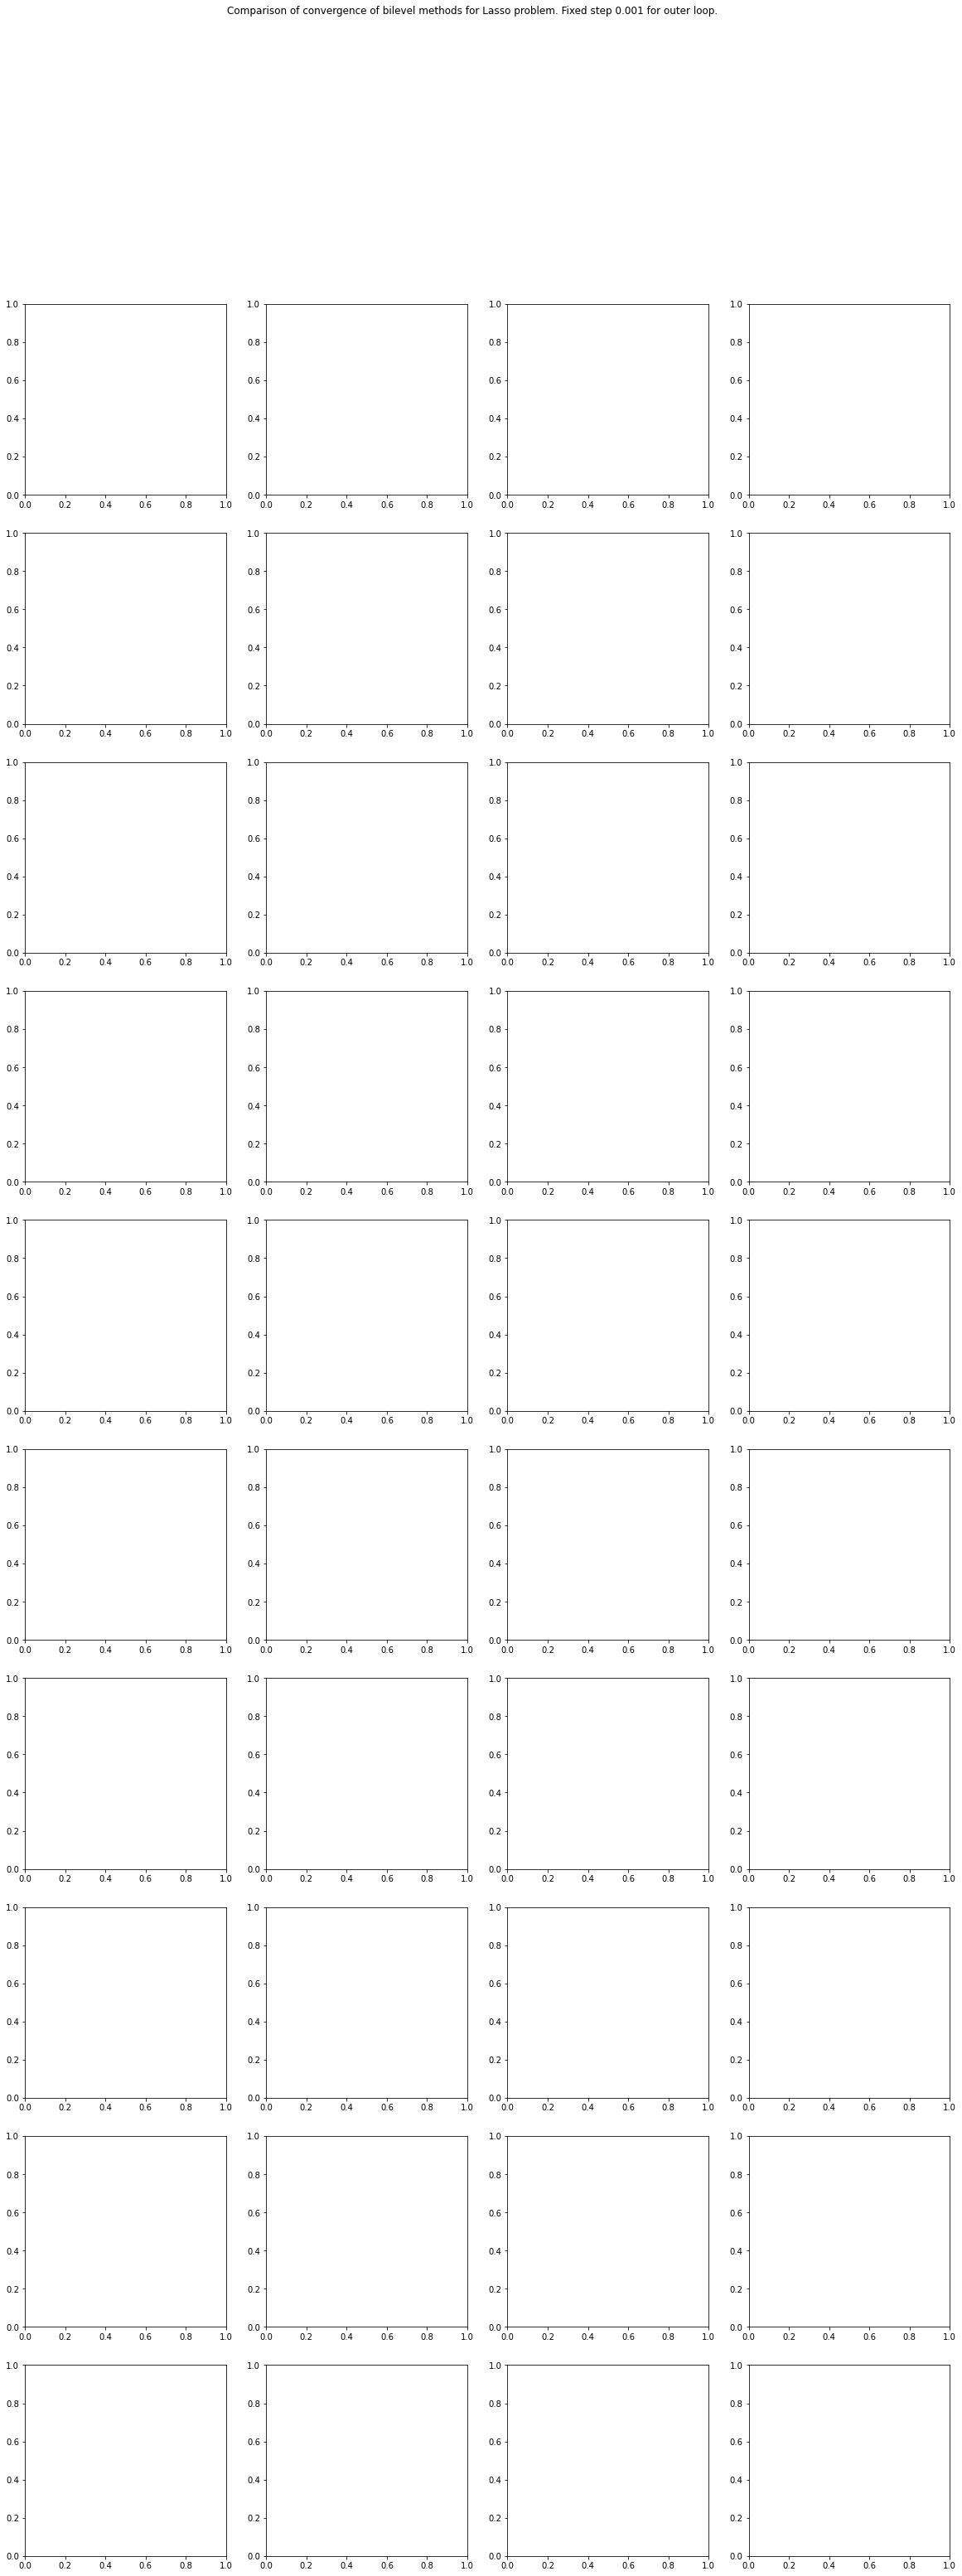

In [102]:
runs = 10
fig, axsf = plt.subplots(runs,lamsz, figsize=(5*lamsz,5*runs))
fig.suptitle('Comparison of convergence of bilevel methods for Lasso problem. Fixed step 0.001 for outer loop.')
for j in range(runs):
    print("Started Run ", j+1," out of ", runs)
    #Create dummy data
    A = np.random.randn(samples,features)
    x0 = np.zeros((features,1))
    p = np.random.permutation(features)
    x0[p[:10]] = np.random.randn(10,1)
    x0 = np.reshape(x0,-1)
    y = A@x0
    lamb = np.array([np.max(np.abs(A.T@y))/50,np.max(np.abs(A.T@y))/25,np.max(np.abs(A.T@y))/10,np.max(np.abs(A.T@y))/5])
    lamsz = np.size(lamb)
    
    ba_orig = BA_ST()
    ba_svrh = BA_SVRH()
    ba_sv_quad = BA_QUAD()
    ba_neumann = BA_NEU()
    
    for i in range(lamsz):
        axsf[j,i].plot(np.log(ba_orig[i,:].T),label='Ghadimi BA');
        axsf[j,i].plot(np.log(ba_svrh[i,:].T),label='BA + Neumann Hess.');
        axsf[j,i].plot(np.log(ba_sv_quad[i,:].T),label='BA + SVRG');
        axsf[j,i].plot(np.log(ba_neumann[i,:].T),label='BA + Quad. Hess.');
        axsf[j,i].legend()
        axsf[j,i].set_title('Run ' + str(j+1) + ', Lamda = ' + str(round(lamb[i],3)))
        axsf[j,i].ticklabel_format(axis='x', style='sci', scilimits=None, useOffset=None, useLocale=None, useMathText=True)
    
fig.savefig('funcvec.png', bbox_inches='tight')
fig.savefig('funcvec.svg', format='svg', dpi=1200)
fig.savefig('funcvec.pdf', format='pdf', dpi=1200)